
# Hipoteza II
Wzrost liczby użytkowników portalu Facebook nie jest nieograniczony i dąży do określonego punktu nasycenia, co sprawia, że model logistyczny będzie charakteryzował się najlepszym dopasowaniem. \
\
Dane treningowe: kwartalne dane liczby użytkowników z lat 2009-2017 \
Dane testowe: kwartalne dane liczby użytkowników z lat 2018-2023 \
\
Wykorzystany model: logistyczny \
Zmienna objaśniana: liczba użytkowniów (Users) \
Zmienna objaśniająca: kwartał (NoQ)


In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

import importlib

from sklearn.metrics import mean_absolute_error

dane = importlib.import_module('Lab-1-Zadanie-1-Przygotowanie-danych')

## Model liniowy
Model liniowy służący jako punkt odwołania dla pozostałych modeli

$Y = X * a + b$

$Y$ -> 'Users' \
$X$ -> 'NoQ'

PODSUMOWANIE MODELU LINIOWEGO (dla danych 2009-2017)

                            OLS Regression Results                            
Dep. Variable:                  Users   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     7613.
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           1.41e-41
Time:                        16:20:02   Log-Likelihood:                -180.55
No. Observations:                  36   AIC:                             365.1
Df Residuals:                      34   BIC:                             368.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

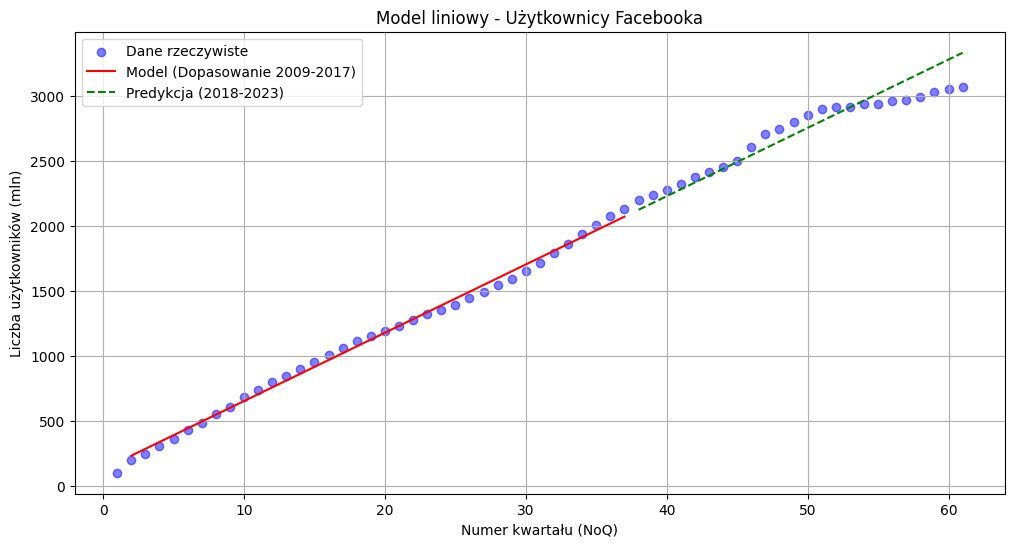

Średni błąd (MAE) dla lat 2018-2020: 55.95 mln
Średni błąd (MAE) dla lat 2021-2023: 124.17 mln


In [2]:
data, data_train, data_test = dane.dane_uzytkownicy()

# Definicja modelu
X_train = data_train['NoQ']
X_train = sm.add_constant(X_train)
Y_train = data_train['Users']

model_liniowy = sm.OLS(Y_train, X_train).fit()


# Ocena modelu
print("PODSUMOWANIE MODELU LINIOWEGO (dla danych 2009-2017)\n")
print(model_liniowy.summary())

X_pred = data_test['NoQ']
X_pred = sm.add_constant(X_pred)
Y_pred = model_liniowy.predict(X_pred)

plt.figure(figsize=(12, 6))
plt.scatter(data['NoQ'], data['Users'], color='blue', label='Dane rzeczywiste', alpha=0.5)
plt.plot(data_train['NoQ'], model_liniowy.fittedvalues, color='red', label='Model (Dopasowanie 2009-2017)')
plt.plot(data_test['NoQ'], Y_pred, color='green', linestyle='--', label='Predykcja (2018-2023)')

plt.title('Model liniowy - Użytkownicy Facebooka')
plt.xlabel('Numer kwartału (NoQ)')
plt.ylabel('Liczba użytkowników (mln)')
plt.legend()
plt.grid(True)
plt.show()

model_liniowy_mae_2018_2020 = mean_absolute_error(
    data_test[data_test['QY'] <= dane.Quarter(4, 2020)]['Users'],
    Y_pred[data_test['QY'] <= dane.Quarter(4, 2020)]
)

model_liniowy_mae_2021_2023 = mean_absolute_error(
    data_test[data_test['QY'] >= dane.Quarter(1, 2021)]['Users'],
    Y_pred[data_test['QY'] >= dane.Quarter(1, 2021)]
)

print(f"Średni błąd (MAE) dla lat 2018-2020: {model_liniowy_mae_2018_2020:.2f} mln")
print(f"Średni błąd (MAE) dla lat 2021-2023: {model_liniowy_mae_2021_2023:.2f} mln")



## Model logistyczny

Funkcja logistyczna opisująca zjawisko \
$$
 W = \frac{k}{1 + b \cdot e^{-a \cdot X}}
$$
,gdzie \
$W$ -> 'Users' \
$X$ -> 'NoQ' \
$k$ -> górna asymptota funkcji - wartość nasycenia rynku

Linearyzacja funkcji: \
$Y = ln(\frac{k-W}{W})$ \
$a_0 = ln(b)$ \
$a_1 = -a$

Równoważny model liniowy:
$Y = a_1 \cdot X + a_0$


Wyznaczona wartość k: 3277.06
PODSUMOWANIE MODELU LOGISTYCZNEGO (dla danych 2009-2017)

                            OLS Regression Results                            
Dep. Variable:                  Users   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     749.6
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           9.50e-25
Time:                        16:20:02   Log-Likelihood:                 10.339
No. Observations:                  36   AIC:                            -16.68
Df Residuals:                      34   BIC:                            -13.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

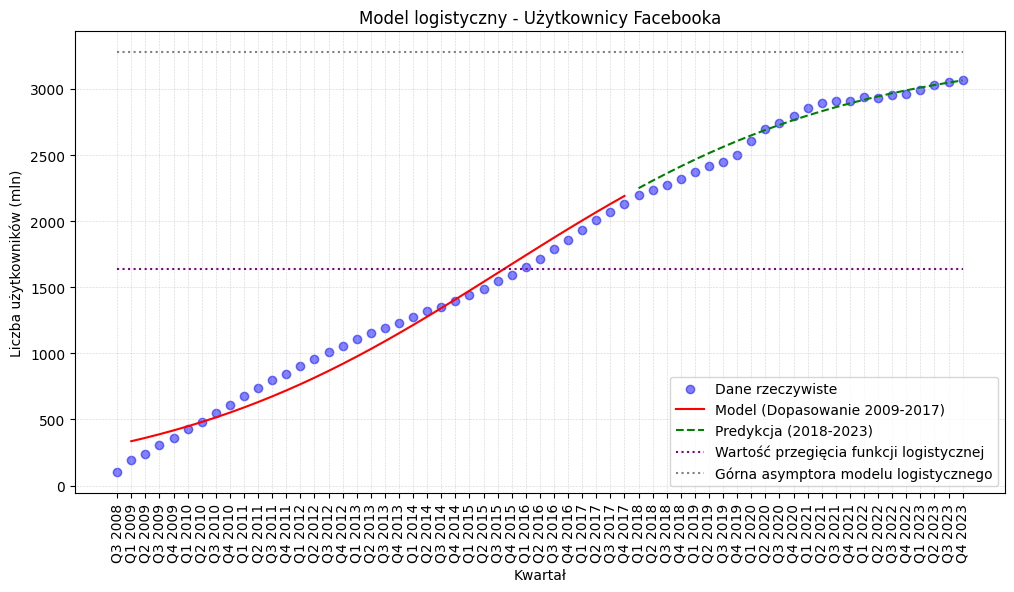

Średni błąd (MAE) dla lat 2018-2020: 68.73 mln
Średni błąd (MAE) dla lat 2021-2023: 22.60 mln


In [3]:
from scipy.optimize import minimize_scalar

data, data_train, data_test = dane.dane_uzytkownicy()

# Definicja modelu
X_train = data_train['NoQ']
X_train = sm.add_constant(X_train)
Y_train = data_train['Users']

def function(k):
    Y = lambda W: np.log((k - W) / W)
    W = lambda Y: k / (np.exp(Y) + 1)
    model_logistyczny = sm.OLS(
        Y(Y_train),
        X_train
    ).fit()
    X_pred = data_test['NoQ']
    X_pred = sm.add_constant(X_pred)
    Y_pred_log = model_logistyczny.predict(X_pred)

    mae_train = mean_absolute_error(
        data_train['Users'],
        W(model_logistyczny.fittedvalues)
    )

    mae_2018_2023 = mean_absolute_error(
        data_test['Users'],
        W(Y_pred_log)
    )

    return mae_train + mae_2018_2023

k = minimize_scalar(function, bounds=(3000, 8000)).x
print(f"Wyznaczona wartość k: {k:.2f}")
Y = lambda W: np.log((k - W) / W)
W = lambda Y: k / (np.exp(Y) + 1)

model_logistyczny = sm.OLS(
    Y(Y_train),
    X_train
).fit()

# Ocena modelu
print("PODSUMOWANIE MODELU LOGISTYCZNEGO (dla danych 2009-2017)\n")
print(model_logistyczny.summary())

X_pred = data_test['NoQ']
X_pred = sm.add_constant(X_pred)
Y_pred_log = model_logistyczny.predict(X_pred)

plt.figure(figsize=(12, 6))
plt.scatter(data['NoQ'], data['Users'], color='blue', label='Dane rzeczywiste', alpha=0.5)
plt.plot(data_train['NoQ'], W(model_logistyczny.fittedvalues), color='red', label='Model (Dopasowanie 2009-2017)')
plt.plot(data_test['NoQ'], W(Y_pred_log), color='green', linestyle='--', label='Predykcja (2018-2023)')
plt.plot(data['NoQ'], [k/2 for x in data['NoQ']], color='purple', linestyle=':', label='Wartość przegięcia funkcji logistycznej')
plt.plot(data['NoQ'], [k for x in data['NoQ']], color='grey', linestyle=':',
         label='Górna asymptora modelu logistycznego')

plt.title('Model logistyczny - Użytkownicy Facebooka')
plt.xlabel('Kwartał')
plt.ylabel('Liczba użytkowników (mln)')
plt.xticks(range(min(data['NoQ']), max(data['NoQ'])+1), labels=data['QY'], rotation=90)
plt.grid(which='major', linestyle=':', linewidth='0.4')
plt.legend()
plt.grid(True)
plt.show()

model_logistyczny_mae_2018_2020 = mean_absolute_error(
    data_test[data_test['QY'] <= dane.Quarter(4, 2020)]['Users'],
    W(Y_pred_log[data_test['QY'] <= dane.Quarter(4, 2020)])
)

model_logistyczny_mae_2021_2023 = mean_absolute_error(
    data_test[data_test['QY'] >= dane.Quarter(1, 2021)]['Users'],
    W(Y_pred_log[data_test['QY'] >= dane.Quarter(1, 2021)])
)

print(f"Średni błąd (MAE) dla lat 2018-2020: {model_logistyczny_mae_2018_2020:.2f} mln")
print(f"Średni błąd (MAE) dla lat 2021-2023: {model_logistyczny_mae_2021_2023:.2f} mln")

